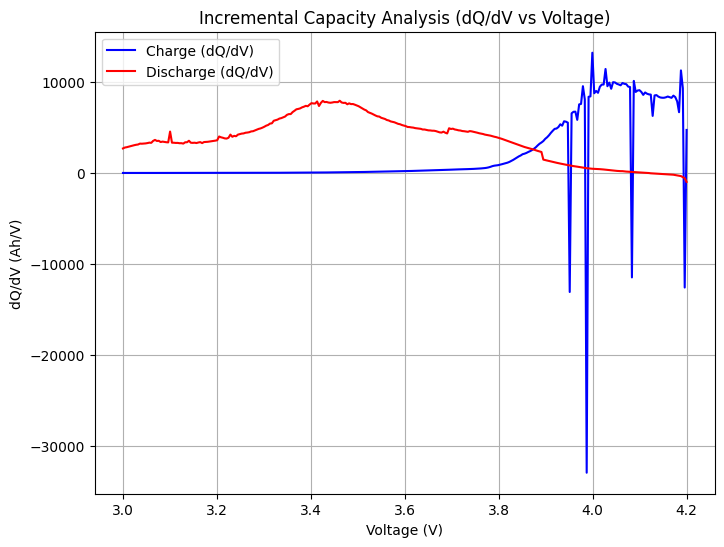

In [4]:
# Incremental Capacity Analysis (dQ/dV) for Charge and Discharge Cycles

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.interpolate import interp1d

metadata_path = "../cleaned_dataset/metadata.csv"
data_dir = "../cleaned_dataset/data/"

metadata = pd.read_csv(metadata_path)
charge_meta = metadata[metadata["type"] == "charge"]
discharge_meta = metadata[metadata["type"] == "discharge"]

def compute_dQdV(voltage, capacity):
    dV = np.gradient(voltage)
    dQ = np.gradient(capacity)
    dQdV = np.divide(dQ, dV, out=np.zeros_like(dQ), where=dV!=0)
    return dQdV

common_voltage = np.linspace(3.0, 4.2, 300)
charge_dQdV_interpolated, discharge_dQdV_interpolated = [], []

for idx, row in charge_meta.iterrows():
    file_path = os.path.join(data_dir, row["filename"])
    if not os.path.exists(file_path):
        continue
    cycle_data = pd.read_csv(file_path)
    voltage = cycle_data["Voltage_measured"].values
    time_diff = np.gradient(cycle_data["Time"].values) 
    capacity = np.cumsum(cycle_data["Current_measured"].values * time_diff)
    dQdV = compute_dQdV(voltage, capacity)
    try:
        interp_func = interp1d(voltage, dQdV, bounds_error=False, fill_value=np.nan)
        charge_dQdV_interpolated.append(interp_func(common_voltage))
    except ValueError:
        continue

for idx, row in discharge_meta.iterrows():
    file_path = os.path.join(data_dir, row["filename"])
    if not os.path.exists(file_path):
        continue
    cycle_data = pd.read_csv(file_path)
    voltage = cycle_data["Voltage_measured"].values
    time_diff = np.gradient(cycle_data["Time"].values) 
    capacity = np.cumsum(cycle_data["Current_measured"].values * time_diff)
    dQdV = compute_dQdV(voltage, capacity)
    try:
        interp_func = interp1d(voltage, dQdV, bounds_error=False, fill_value=np.nan)
        discharge_dQdV_interpolated.append(interp_func(common_voltage))
    except ValueError:
        continue

charge_dQdV_mean = np.nanmean(charge_dQdV_interpolated, axis=0)
discharge_dQdV_mean = np.nanmean(discharge_dQdV_interpolated, axis=0)

plt.figure(figsize=(8, 6))
plt.plot(common_voltage, charge_dQdV_mean, color="blue", label="Charge (dQ/dV)")
plt.plot(common_voltage, discharge_dQdV_mean, color="red", label="Discharge (dQ/dV)")
plt.xlabel("Voltage (V)")
plt.ylabel("dQ/dV (Ah/V)")
plt.title("Incremental Capacity Analysis (dQ/dV vs Voltage)")
plt.legend()
plt.grid(True)
plt.show()